## Import libraries and dataset

In [1]:
from SoundDS import SoundDS
from AutoEncoder import AutoEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchaudio
from torchaudio import transforms
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path_do_data_dir = 'DATA/'

# Get the list of files in the 'Piano Loops' directory using os.listdir()
piano_file_list = [path_do_data_dir + 'Piano Loops/' + filename for filename in os.listdir(path_do_data_dir + 'Piano Loops')]

# Create a pandas DataFrame with the "path_to_data" and "Instrument" columns for "Piano" entries
piano_df = pd.DataFrame({"path_to_data": piano_file_list, "Instrument": "Piano"})

# Get the list of files in the 'Guitar Loops' directory using os.listdir()
guitar_file_list = [path_do_data_dir + 'Guitar Loops/' + filename for filename in os.listdir(path_do_data_dir + 'Guitar Loops')]

# Create a DataFrame with the "path_to_data" and "Instrument" columns for "Guitar" entries
guitar_df = pd.DataFrame({"path_to_data": guitar_file_list, "Instrument": "Guitar"})


In [3]:
sample_rate = 5000
piano_ds = SoundDS(piano_df, sr = sample_rate, duration = 7)
guitar_ds = SoundDS(guitar_df, sr = sample_rate, duration = 7)

# Create data loaders
dl = DataLoader(guitar_ds, batch_size=1, shuffle=False)

In [4]:
for data in dl:
    pass

In [5]:
size = data.shape[1]
size

35397

## Define AutoEncoder

In [6]:
enc_layers = [size, 8000, 3000, 1000, 800, 600 ]
dec_layers = enc_layers[::-1]
autoencoder_piano = AutoEncoder(enc_layers, dec_layers)

In [7]:
piano_ds_train, piano_ds_test = random_split(piano_ds, [len(piano_ds) - 2, 2])
guitar_ds_train, guitar_ds_test = random_split(piano_ds, [len(piano_ds) - 2, 2])


In [19]:
autoencoder_piano.train(piano_ds_train, lr = 0.0001, batch_size = 16, epochs = 20, verbose = 3, optimizer = 'adam')

Epoch: 1 | Batch number: 3 | Loss: 5546.12158203125 | Time: 66.46 s
Epoch: 1 | Batch number: 6 | Loss: 10698.16015625 | Time: 63.21 s
Epoch: 2 | Batch number: 3 | Loss: 11957.8056640625 | Time: 92.5 s
Epoch: 2 | Batch number: 6 | Loss: 12681.7392578125 | Time: 63.93 s
Epoch: 3 | Batch number: 3 | Loss: 5114.39599609375 | Time: 90.15 s
Epoch: 3 | Batch number: 6 | Loss: 7428.30126953125 | Time: 59.61 s
Epoch: 4 | Batch number: 3 | Loss: 4376.86669921875 | Time: 85.0 s
Epoch: 4 | Batch number: 6 | Loss: 3934.10693359375 | Time: 61.12 s
Epoch: 5 | Batch number: 3 | Loss: 8133.42333984375 | Time: 89.19 s
Epoch: 5 | Batch number: 6 | Loss: 4072.871826171875 | Time: 62.98 s
Epoch: 6 | Batch number: 3 | Loss: 6831.65234375 | Time: 81.56 s
Epoch: 6 | Batch number: 6 | Loss: 4786.06103515625 | Time: 59.27 s
Epoch: 7 | Batch number: 3 | Loss: 7142.57421875 | Time: 80.62 s
Epoch: 7 | Batch number: 6 | Loss: 4789.66943359375 | Time: 60.79 s
Epoch: 8 | Batch number: 3 | Loss: 6418.0849609375 | Time

[3708.588134765625,
 3682.043701171875,
 27199.0390625,
 2887.0576171875,
 1114.8427734375,
 2278.866455078125,
 4264.91796875,
 31750.251953125,
 12861.388671875,
 4213.5458984375,
 6620.7275390625,
 1182.635986328125,
 2816.661865234375,
 6807.6953125,
 2864.53955078125,
 5633.88134765625,
 51448.171875,
 2656.62158203125,
 5029.58984375,
 9075.98046875]

In [9]:
def recover_waveform(spec):
        griffin_lim = transforms.GriffinLim()

        rec_waveform = griffin_lim(spec)

        return rec_waveform

In [20]:
out = autoencoder_piano(piano_ds_test[0])

out_shaped = out.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach()
out_wave = recover_waveform(out_shaped)

output_path = "output_audio.wav"
torchaudio.save(output_path, out_wave, sample_rate)

In [21]:
out_wave

tensor([[nan, nan, nan,  ..., nan, nan, nan]])

In [17]:
piano_ds_test[0]

tensor([1.3635e-01, 1.5399e-01, 1.7156e-01,  ..., 3.7641e-06, 4.7569e-09,
        3.8656e-07])

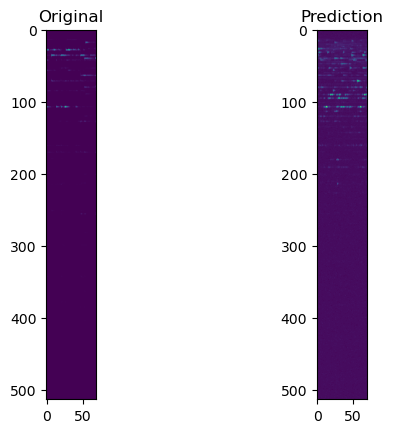

In [23]:
fig = plt.figure()

fig.add_subplot(1,2,2)
plt.imshow(out_shaped.detach().numpy()[0])
plt.title('Prediction')

fig.add_subplot(1,2,1)
plt.imshow(piano_ds_test[1].numpy().reshape(*piano_ds.spec_size))
plt.title('Original')
plt.show()

In [25]:
torch.save(autoencoder_piano.state_dict(), 'model_parameters_piano_8000_3000_1000_800_600.pth')